In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/TextClassification")

In [65]:
!pip install -r requirements.txt

     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 29.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=b11dc22c0ffa7cf3dba4ae0fb7b8a470fac1bf4e36551a39beee5a0a666b3b38
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=67427f6a5f9d2677c4a6810fa6a0915624f79ade6f3b1c9044a2ad2045d7fb69
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [4]:
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are {all_datasets[:10]}")

There are 4554 datasets currently available on the Hub
The first 10 are ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [6]:
emotions_dataset = load_dataset("emotion")
emotions_dataset

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Analyze dataset

In [7]:
train_ds = emotions_dataset["train"]
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)
print(train_ds[:5])

{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [8]:
emotions_dataset.set_format(type="pandas")
df = emotions_dataset["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
def label_int2str(row):
  return emotions_dataset["train"].features["label"].int2str(row)

In [10]:
df["label_name"] = df["label"].apply(label_int2str)

In [11]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Class Distribution

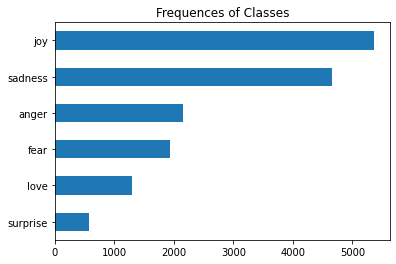

In [12]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequences of Classes")
plt.show()

### Tweets length

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


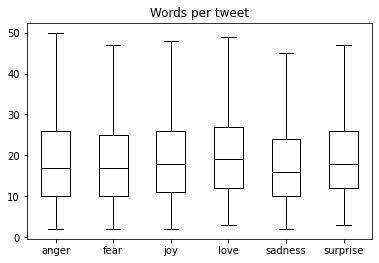

In [13]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions_dataset.reset_format()

## Tokenization

In [42]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

In [28]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [46]:
emotions_dataset_encoded = emotions_dataset.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-a5bb0089cecb7c78.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-a3e8ac34c2a58a50.arrow


In [26]:
emotions_dataset_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [52]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state  = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [53]:
emotions_dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_dataset_hidden = emotions_dataset_encoded.map(extract_hidden_states, batched=True)
emotions_dataset_hidden["train"].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Create feature matrix

In [54]:
X_train = np.array(emotions_dataset_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_dataset_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_dataset_hidden["train"]["label"])
y_valid = np.array(emotions_dataset_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualize training set

In [122]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [67]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a dataframe for 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.258591,6.119018,0
1,-3.083768,5.622069,0
2,5.136472,2.651776,3
3,-2.458760,3.076678,2
4,-3.340415,3.727398,3


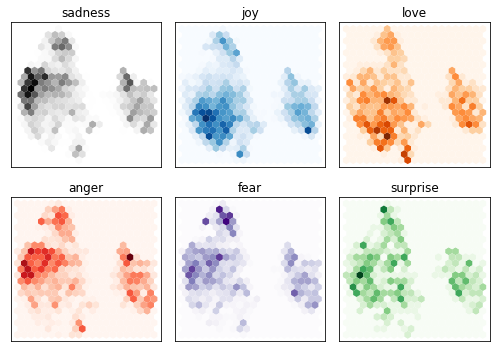

In [114]:
fix, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Train a simple classifier

In [115]:
# Increase 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [116]:
# Compare with a dummy baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [131]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
  plt.title("Normalized confusion matrix")
  plt.show()

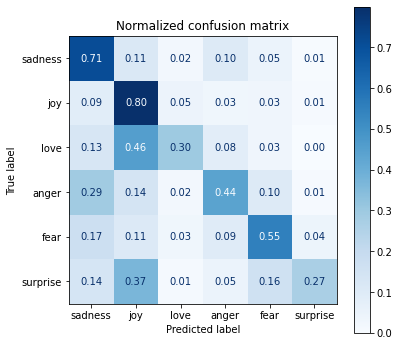

In [132]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)